In [18]:
library(tidyverse)
library(data.table)
library(lme4)
library(ggrepel)
library(cowplot)

In [2]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/joonklaps/opt/anaconda3/lib/libopenblasp-r0.3.20.dylib

locale:
[1] C/C.UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.3     ggrepel_0.9.5     lme4_1.1-35.3     Matrix_1.6-5     
 [5] data.table_1.15.4 lubridate_1.9.3   forcats_1.0.0     stringr_1.5.1    
 [9] dplyr_1.1.4       purrr_1.0.2       readr_2.1.5       tidyr_1.3.1      
[13] tibble_3.2.1      ggplot2_3.5.2     tidyverse_2.0.0  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.13        nloptr_2.0.3       pillar_1.10.2      compiler_4.2.1    
 [5] RColorBrewer_1.1-3 base64enc_0.1-3    tools_4.2.1        boot_1.3-30       
 [9] digest_0.6.36      uuid_1.2-0         nlme_3.1-162       lattice_0.22-6    
[13] timechange_0.3.0   jsonlite_1.8.8     evaluate_1

### Influence of Reference Genetic Distance on Consensus Variety

Let's examine how the genetic distance of the reference genome influences the final consensus sequence. The hypothesis is that more divergent references (lower similarity to MN090277.1) should allow for more variety in the consensus sequences.

Reference similarities to MN090277.1:

-   MN090277.1: 100% (self)
-   MN090188.1: 98.7% similarity
-   MN090240.1: 96.7% similarity
-   MZ766668.1: 83.5% similarity


In [3]:
# Create a reference similarity mapping
reference_global_alignment <- read.csv("./data/influence-reference/consensus-vs-ref.csv")%>%
    rename( query = "X", subject = "X.1", reference = "db")
head(reference_global_alignment)

,query,subject,gaps,identities,mismatches,query_length,number_of_gaps,number_of_Ns,alignment_length,got,reference,alignment_path
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,Arya-MN090240_cl0_it2.consensus_ivar,MN090240.1,0,9013,2,9015,0,1,9015,Arya,MN090240,./data/influence-reference/alignment-vs-ref//Arya.MN090240_cl0_it2.consensus_ivar.vs.MN090240.1.aln
2,Arya-MN090240_cl0_it2.consensus_ivar,MN090277.1,223,8731,281,9235,220,1,9235,Arya,MN090240,./data/influence-reference/alignment-vs-ref//Arya.MN090240_cl0_it2.consensus_ivar.vs.MN090277.1.aln
3,Arya-MN090277-MN090240_cl0_it2.consensus_ivar,MN090240.1,210,9015,0,9225,0,1,9225,Arya,MN090277-MN090240,./data/influence-reference/alignment-vs-ref//Arya.MN090277.MN090240_cl0_it2.consensus_ivar.vs.MN090240.1.aln
4,Arya-MN090277-MN090240_cl0_it2.consensus_ivar,MN090277.1,13,8940,282,9235,10,1,9235,Arya,MN090277-MN090240,./data/influence-reference/alignment-vs-ref//Arya.MN090277.MN090240_cl0_it2.consensus_ivar.vs.MN090277.1.aln
5,Arya-MN090277_cl0_it2.consensus_ivar,MN090240.1,210,9015,0,9225,0,1,9225,Arya,MN090277,./data/influence-reference/alignment-vs-ref//Arya.MN090277_cl0_it2.consensus_ivar.vs.MN090240.1.aln
6,Arya-MN090277_cl0_it2.consensus_ivar,MN090277.1,13,8940,282,9235,10,1,9235,Arya,MN090277,./data/influence-reference/alignment-vs-ref//Arya.MN090277_cl0_it2.consensus_ivar.vs.MN090277.1.aln


`summarise()` has grouped output by 'got'. You can override using the `.groups`
argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'difference_type'. You can override using
the `.groups` argument.


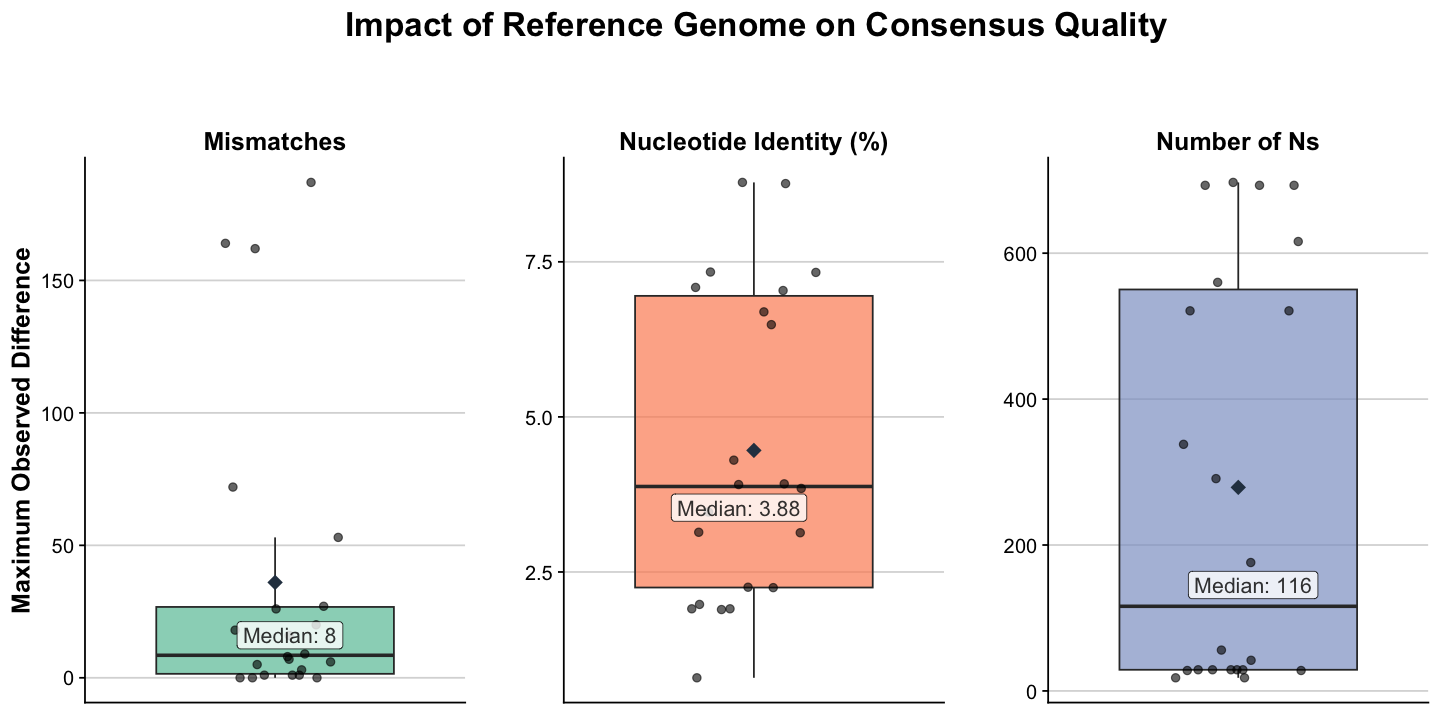

In [19]:
summarised_diff <- reference_global_alignment%>%
    group_by(got,subject,reference)%>%
    arrange(desc(identities),mismatches, number_of_gaps)%>%
    slice(1)%>%
    group_by(got,subject)%>%
    summarise(max_difference_identity_perc = max((identities/alignment_length)*100) - min((identities/alignment_length)*100),
                max_difference_mismatches = max(mismatches) - min(mismatches),
                max_difference_Ns = max(number_of_Ns) - min(number_of_Ns))%>%
    ungroup()%>%
    pivot_longer(cols = starts_with("max_difference_"), names_to = "difference_type", values_to = "difference_value")%>%
    mutate(difference_type = recode(difference_type,
                                     max_difference_identity_perc = "Nucleotide Identity (%)",
                                     max_difference_mismatches = "Mismatches",
                                     max_difference_Ns = "Number of Ns"))

median_mean <- summarised_diff %>%
    mutate(round_value = ifelse(grepl("Identity", difference_type), 2, 0)) %>%
    group_by(difference_type) %>%
    summarise(median = round(median(difference_value), round_value),
              mean = round(mean(difference_value), round_value))%>%
    unique()


p <- summarised_diff %>%
    ggplot(aes(x="", y=difference_value, fill=difference_type)) +
    geom_boxplot(outlier.shape = NA, alpha = 0.7) +
    geom_jitter(width=0.2, height=0, alpha=0.6, size=2) +
    facet_wrap(~difference_type, scales="free", nrow=1) +
    scale_fill_brewer(palette = "Set2") +
    labs(title="Impact of Reference Genome on Consensus Quality",
            subtitle="",
         x="",
         y="Maximum Observed Difference") +
    theme_cowplot() +
    background_grid(major = "y", minor = "none") +
    geom_label_repel(data=median_mean, aes(y=median, label=paste("Median:", median)),
                     color="black", size=4.5, fill="white", alpha=0.8) +
    geom_point(data=median_mean, aes(y=mean), size=4, shape=18, color="#2c3e50") +
    theme(
        panel.spacing = unit(2.5, "lines"),
        legend.position = "none",
        plot.title = element_text(hjust = 0.5, size = 20, face = "bold", margin = margin(b = 8)),
        plot.subtitle = element_text(hjust = 0.5, size = 16, color = "gray40", margin = margin(b = 25)),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.y = element_text(size = 12),
        strip.text = element_text(size = 15, face = "bold"),
        strip.background = element_blank()
    )

options(repr.plot.width = 12, repr.plot.height = 6)
p

ggsave("./global_alignment_references_differences.pdf", plot = p, width = 12, height = 6, dpi = 900)
ggsave("../../Fig/fig2.pdf", plot = p, width = 12, height = 6, dpi = 900)
ggsave("./global_alignment_references_differences.png", plot = p, width = 12, height = 6, dpi = 900)
ggsave("../../Fig/fig2.png", plot = p, width = 12, height = 6, dpi = 900)


In [7]:
df <- rbindlist(list(
        "Hybrid Skipped" = read.csv("./data/hybrid-vs-skiphybrid/skiphybrid-vs-ref.csv", stringsAsFactors = FALSE),
        "Hybrid Not Skipped" = read.csv("./data/hybrid-vs-skiphybrid/hybrid-vs-ref.csv", stringsAsFactors = FALSE)
    ), idcol = "hybrid_status") %>%
    rename( query = "X", subject = "X.1", reference = "db")

In [8]:
# Filter for it2 (final consensus) and calculate %identity
df_processed <- df %>%
  group_by(hybrid_status, got,subject,reference) %>%
  filter(grepl("it2",query)) %>%
  arrange(desc(identities),mismatches, number_of_gaps)%>%
  slice(1) %>%
  mutate(percent_identity = (identities / alignment_length) * 100)

# Show some summary statistics
df_processed %>%
  group_by(hybrid_status) %>%
  summarise(
    mean_identities = mean(percent_identity),
    mean_Ns = mean(number_of_Ns),
    n_samples = n()
  )

hybrid_status,mean_identities,mean_Ns,n_samples
<chr>,<dbl>,<dbl>,<int>
Hybrid Not Skipped,96.53796,120.3333,114
Hybrid Skipped,96.61425,124.4649,114


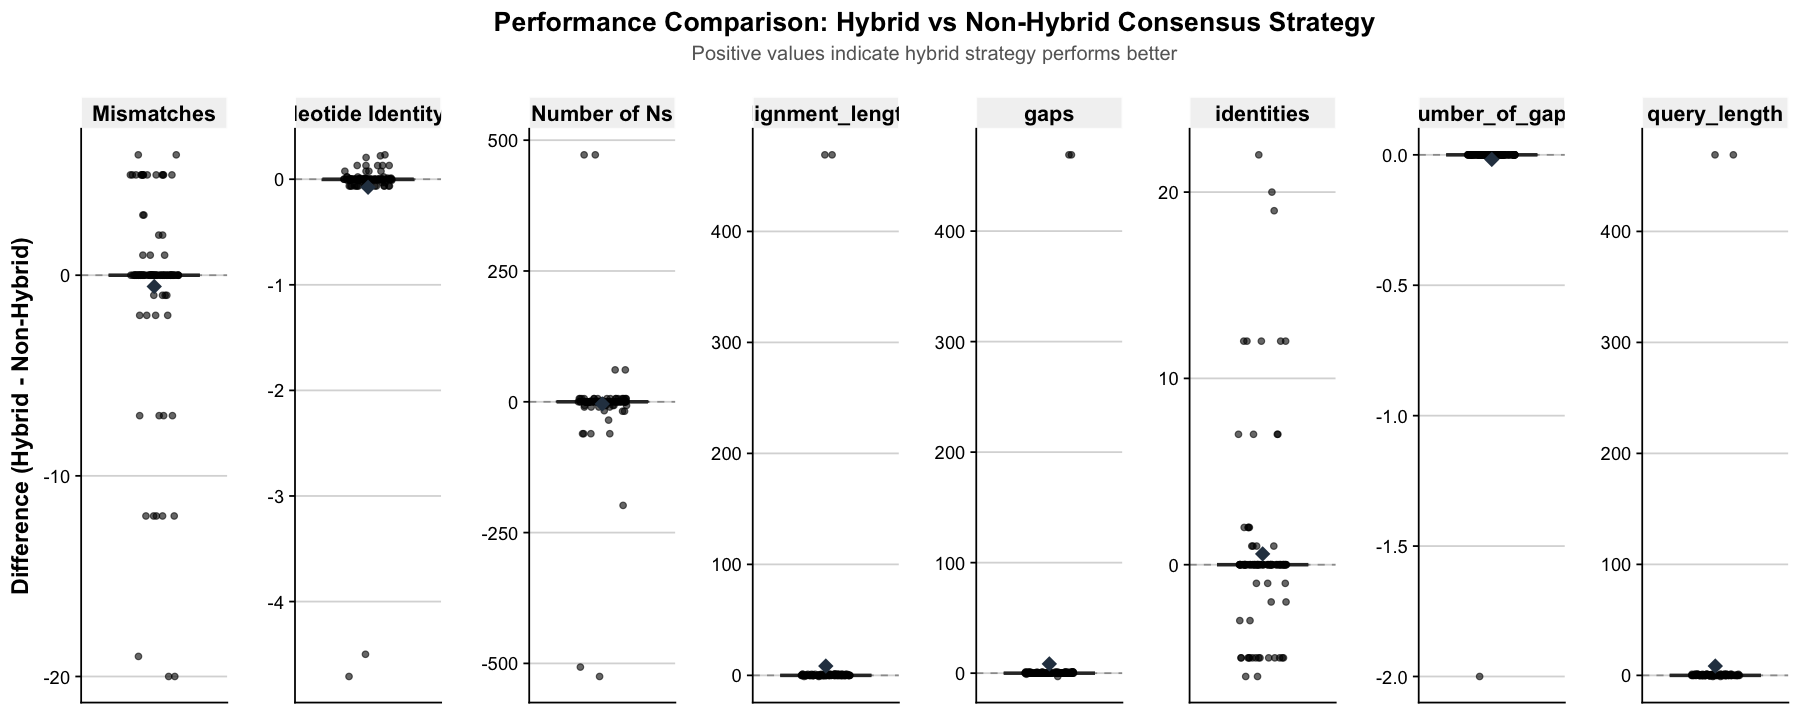

In [9]:
# Pivot data to longer format for faceted plotting
hybrid_summ <- df_processed %>%
    pivot_longer(cols = c(identities, alignment_length, mismatches, number_of_Ns,percent_identity, gaps,query_length,number_of_gaps), names_to = "difference_type", values_to = "difference_value")%>%
    select(-c(query, alignment_path)) %>%
    pivot_wider(names_from = hybrid_status, values_from = difference_value) %>%
    mutate(difference_value = `Hybrid Not Skipped` - `Hybrid Skipped`,
           difference_type = recode(difference_type,
                                    percent_identity = "Nucleotide Identity (%)",
                                    mismatches = "Mismatches",
                                    number_of_Ns = "Number of Ns"))

hybrid_median_mean <- hybrid_summ %>%
    group_by(difference_type) %>%
    summarise(median = median(difference_value),
              mean = mean(difference_value))

p <- hybrid_summ %>%
    ggplot(aes(x="", y=difference_value, fill=difference_type)) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray50", alpha = 0.7) +
    geom_boxplot(outlier.shape = NA, alpha = 0.7) +
    geom_jitter(width=0.2, height=0, alpha=0.6, size=1.5) +
    facet_wrap(~difference_type, scales="free", nrow=1) +
    scale_fill_brewer(palette = "Set2") +
    labs(title="Performance Comparison: Hybrid vs Non-Hybrid Consensus Strategy",
         subtitle="Positive values indicate hybrid strategy performs better",
         x="",
         y="Difference (Hybrid - Non-Hybrid)") +
    theme_cowplot() +
    background_grid(major = "y", minor = "none") +
    geom_point(data=hybrid_median_mean, aes(y=mean), shape=18, color="#2c3e50", size=4) +
    theme(
        panel.spacing = unit(1.5, "lines"),
        legend.position = "none",
        plot.title = element_text(hjust = 0.5, size = 16, face = "bold", margin = margin(b = 5)),
        plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40", margin = margin(b = 20)),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14, face = "bold"),
        axis.text.y = element_text(size = 11),
        strip.text = element_text(size = 13, face = "bold"),
        strip.background = element_rect(fill = "gray95", color = "white")
    )

options(repr.plot.width = 15, repr.plot.height = 6)
p
ggsave("./data/hybrid-vs-skiphybrid/hybrid_vs_skiphybrid_global_alignment_differences.png", plot = p, width = 15, height = 6, dpi = 300)


In [10]:
hybrid_median_mean

difference_type,median,mean
<chr>,<dbl>,<dbl>
Mismatches,0,-0.56140351
Nucleotide Identity (%),0,-0.07629364
Number of Ns,0,-4.13157895
alignment_length,0,8.40350877
gaps,0,8.38596491
identities,0,0.57894737
number_of_gaps,0,-0.01754386
query_length,0,8.40350877


In [11]:
hybrid_summ%>%arrange(desc(difference_value))%>%
    head()

subject,got,reference,difference_type,Hybrid Not Skipped,Hybrid Skipped,difference_value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
MN090240.1,Jon,virosaurus,Number of Ns,693,221,472
MN090277.1,Jon,virosaurus,Number of Ns,693,221,472
MN090240.1,Jon,virosaurus,alignment_length,9766,9297,469
MN090240.1,Jon,virosaurus,gaps,754,285,469
MN090240.1,Jon,virosaurus,query_length,9766,9297,469
MN090277.1,Jon,virosaurus,alignment_length,9763,9294,469


For the sample combination 'Jon' with the reference library of virosaurus, we got significantly much worse results.


In [12]:
df_processed%>%filter(got =="Jon", reference=="virosaurus")

hybrid_status,query,subject,gaps,identities,mismatches,query_length,number_of_gaps,number_of_Ns,alignment_length,got,reference,alignment_path,percent_identity
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
Hybrid Not Skipped,Jon-virosaurus_cl0_it2.consensus_ivar,MN090240.1,754,8731,281,9766,3,693,9766,Jon,virosaurus,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Jon.virosaurus_cl0_it2.consensus_ivar.vs.MN090240.1.aln,89.40201
Hybrid Not Skipped,Jon-virosaurus_cl0_it2.consensus_ivar,MN090277.1,531,9070,162,9763,0,693,9763,Jon,virosaurus,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Jon.virosaurus_cl0_it2.consensus_ivar.vs.MN090277.1.aln,92.90177
Hybrid Skipped,Jon-virosaurus_cl6_it2.consensus_ivar,MN090240.1,285,8730,282,9297,3,221,9297,Jon,virosaurus,./data/hybrid-vs-skiphybrid/skiphybrid-vs-ref//Jon.virosaurus_cl6_it2.consensus_ivar.vs.MN090240.1.aln,93.90126
Hybrid Skipped,Jon-virosaurus_cl6_it2.consensus_ivar,MN090277.1,62,9072,160,9294,0,221,9294,Jon,virosaurus,./data/hybrid-vs-skiphybrid/skiphybrid-vs-ref//Jon.virosaurus_cl6_it2.consensus_ivar.vs.MN090277.1.aln,97.61136


In [13]:
hybrid_summ%>%arrange(difference_value)%>%
    filter(difference_type == "identities")%>%
    head()

subject,got,reference,difference_type,Hybrid Not Skipped,Hybrid Skipped,difference_value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
MN090277.1,Tyrion,MN090277,identities,9029,9035,-6
MN090277.1,Tyrion,MN090277-MZ766668,identities,9029,9035,-6
MN090277.1,Arya,virosaurus,identities,8778,8783,-5
MN090277.1,Bran,virosaurus,identities,9068,9073,-5
MN090277.1,Catelyn,reference,identities,9030,9035,-5
MN090277.1,Catelyn,virosaurus,identities,9030,9035,-5


In [14]:
df_processed%>%filter(got =="Tyrion", subject=="MN090277.1", grepl("MN090277",reference))

hybrid_status,query,subject,gaps,identities,mismatches,query_length,number_of_gaps,number_of_Ns,alignment_length,got,reference,alignment_path,percent_identity
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
Hybrid Not Skipped,Tyrion-MN090277_cl0_it2.consensus_ivar,MN090277.1,4,9029,203,9236,0,1,9236,Tyrion,MN090277,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Tyrion.MN090277_cl0_it2.consensus_ivar.vs.MN090277.1.aln,97.75877
Hybrid Not Skipped,Tyrion-MN090277-MZ766668_cl0_it2.consensus_ivar,MN090277.1,4,9029,203,9236,0,1,9236,Tyrion,MN090277-MZ766668,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Tyrion.MN090277.MZ766668_cl0_it2.consensus_ivar.vs.MN090277.1.aln,97.75877
Hybrid Skipped,Tyrion-MN090277_cl0_it2.consensus_ivar,MN090277.1,4,9035,197,9236,0,1,9236,Tyrion,MN090277,./data/hybrid-vs-skiphybrid/skiphybrid-vs-ref//Tyrion.MN090277_cl0_it2.consensus_ivar.vs.MN090277.1.aln,97.82373
Hybrid Skipped,Tyrion-MN090277-MZ766668_cl0_it2.consensus_ivar,MN090277.1,4,9035,197,9236,0,1,9236,Tyrion,MN090277-MZ766668,./data/hybrid-vs-skiphybrid/skiphybrid-vs-ref//Tyrion.MN090277.MZ766668_cl0_it2.consensus_ivar.vs.MN090277.1.aln,97.82373


# Doing a mixed-effect logistic regression to see if there is a significant relationship


In [15]:
head(df_processed)

hybrid_status,query,subject,gaps,identities,mismatches,query_length,number_of_gaps,number_of_Ns,alignment_length,got,reference,alignment_path,percent_identity
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
Hybrid Not Skipped,Arya-MN090240_cl0_it2.consensus_ivar,MN090240.1,0,9013,2,9015,0,1,9015,Arya,MN090240,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Arya.MN090240_cl0_it2.consensus_ivar.vs.MN090240.1.aln,99.97781
Hybrid Not Skipped,Arya-MN090277_cl0_it2.consensus_ivar,MN090240.1,210,9015,0,9225,0,1,9225,Arya,MN090277,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Arya.MN090277_cl0_it2.consensus_ivar.vs.MN090240.1.aln,97.72358
Hybrid Not Skipped,Arya-MN090277-MN090240_cl0_it2.consensus_ivar,MN090240.1,210,9015,0,9225,0,1,9225,Arya,MN090277-MN090240,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Arya.MN090277.MN090240_cl0_it2.consensus_ivar.vs.MN090240.1.aln,97.72358
Hybrid Not Skipped,Arya-reference_cl1_it2.consensus_ivar,MN090240.1,449,9014,1,9464,0,339,9464,Arya,reference,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Arya.reference_cl1_it2.consensus_ivar.vs.MN090240.1.aln,95.24514
Hybrid Not Skipped,Arya-virosaurus_cl1_it2.consensus_ivar,MN090240.1,273,9014,1,9288,0,227,9288,Arya,virosaurus,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Arya.virosaurus_cl1_it2.consensus_ivar.vs.MN090240.1.aln,97.04996
Hybrid Not Skipped,Arya-MN090240_cl0_it2.consensus_ivar,MN090277.1,223,8731,281,9235,220,1,9235,Arya,MN090240,./data/hybrid-vs-skiphybrid/hybrid-vs-ref//Arya.MN090240_cl0_it2.consensus_ivar.vs.MN090277.1.aln,94.54250


In [16]:
logit <- glmer(as.factor(hybrid_status) ~ gaps + mismatches + number_of_Ns + alignment_length + identities + (1|got:subject) + (1|reference), data = df_processed, family = binomial(link = "logit"))


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

boundary (singular) fit: see help('isSingular')



In [17]:
logit%>%summary()

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: as.factor(hybrid_status) ~ gaps + mismatches + number_of_Ns +  
    alignment_length + identities + (1 | got:subject) + (1 |      reference)
   Data: df_processed

     AIC      BIC   logLik deviance df.resid 
   329.1    353.2   -157.6    315.1      221 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0770 -1.0106  0.1221  0.9817  1.0830 

Random effects:
 Groups      Name        Variance Std.Dev.
 got:subject (Intercept) 0        0       
 reference   (Intercept) 0        0       
Number of obs: 228, groups:  got:subject, 22; reference, 9

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       9.024e+00  4.438e-01  20.334   <2e-16 ***
gaps             -3.633e-04  1.112e-03  -0.327    0.744    
mismatches       -2.173e-05  4.975e-04  -0.044    0.965    
number_of_Ns      1.235e-03  1.226e-03   1.007   

In [98]:
help('isSingular')

isSingular                package:lme4                 R Documentation

_T_e_s_t _F_i_t_t_e_d _M_o_d_e_l _f_o_r (_N_e_a_r) _S_i_n_g_u_l_a_r_i_t_y

_D_e_s_c_r_i_p_t_i_o_n:

     Evaluates whether a fitted mixed model is (almost / near)
     singular, i.e., the parameters are on the boundary of the feasible
     parameter space: variances of one or more linear combinations of
     effects are (close to) zero.

_U_s_a_g_e:

     isSingular(x, tol = 1e-4)
     
_A_r_g_u_m_e_n_t_s:

       x: a fitted ‘merMod’ object (result of ‘lmer’ or ‘glmer’).

     tol: numerical tolerance for detecting singularity.

_D_e_t_a_i_l_s:

     Complex mixed-effect models (i.e., those with a large number of
     variance-covariance parameters) frequently result in _singular_
     fits, i.e. estimated variance-covariance matrices with less than
     full rank. Less technically, this means that some "dimensions" of
     the variance-covariance ma

Likely overfitting. So we cannot be certain.
